# [LSTM Networks](http://www.bioinf.jku.at/publications/older/2604.pdf)

>Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. They were introduced by Hochreiter & Schmidhuber (1997). They work tremendously well on a large variety of problems, and are now widely used.

>LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn!

>All recurrent neural networks have the form of a chain of repeating modules of neural network. In standard RNNs, this repeating module will have a very simple structure, such as a single tanh layer.

<img src ="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-SimpleRNN.png">

> LSTMs also have this chain like structure, but the repeating module has a different structure. Instead of having a single neural network layer, there are four, interacting in a very special way.

<img src ="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png">

* In LSTM we have three gates namely 

1. forget gate (to decide what information we’re going to throw away from the cell state.)
2. Input gate (to decide what new information we’re going to store in the cell state.)
3. Output Gate ( to decide what we’re going to output. This output will be based on our cell state, but will be a filtered version)


# Implementation of Sentiment Classification using LSTMs


In [60]:
# Credits: https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/
# LSTM for sequence classification in the IMDB dataset
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense,LSTM,Embedding,GRU
# fix random seed for reproducibility
import tensorflow as tf
np.random.seed(7)
from sklearn.model_selection import train_test_split
from tqdm import tqdm
tqdm.pandas()
#!pip install keras-tuner 
import keras_tuner as kt
from tensorflow.keras.utils import plot_model


In [2]:
#Refer: https://keras.io/datasets/#imdb-movie-reviews-sentiment-classification

# load the dataset but only keep the top n words, zero the rest
num_words = 10000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words = num_words)

17464789/17464789 [==============================] - 2s 0us/step


In [3]:
X = np.row_stack((X_train.reshape(-1,1),X_test.reshape(-1,1)))
y = np.row_stack((y_train.reshape(-1,1),y_test.reshape(-1,1)))
print(X.shape)
print(y.shape)

(50000, 1)
(50000, 1)


In [4]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25,stratify = y)
X_train = X_train.reshape((X_train.shape[0],))
X_test = X_test.reshape((X_test.shape[0],))
y_train = y_train.reshape((y_train.shape[0],))
y_test = y_test.reshape((y_test.shape[0],))
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(37500,)
(12500,)
(37500,)
(12500,)


In [5]:
print(X_train[1])
print(type(X_train[1]))
print(len(X_train[1]))

[1, 7723, 6417, 659, 2, 4023, 39, 2, 4134, 103, 4052, 4, 341, 7, 160, 2658, 3006, 4601, 238, 181, 8, 276, 90, 23, 27, 768, 7, 2, 21, 4, 85, 9331, 713, 18, 260, 90, 187, 10, 10, 1680, 18, 2, 2, 2, 56, 19, 35, 7095, 3410, 123, 2056, 6579, 5354, 871, 2648, 90, 2, 5, 269, 8, 9938, 23, 2, 78, 2, 240, 188, 8, 193, 12, 21, 2, 2, 871, 2, 577, 1568, 160, 282, 8, 1231, 187, 10, 10, 4, 360, 7, 4, 22, 9, 2, 1651, 8, 79, 145, 8, 4, 2, 9813, 137, 33, 4, 172, 58, 2, 199, 2, 5, 27, 2028, 250, 464, 4289, 2, 1276, 13, 62, 28, 623, 2, 59, 47, 12, 32, 120, 2, 10, 10, 7723, 6417, 9, 1678, 34, 1622, 1205, 33, 4, 2929, 2, 4134, 5, 52, 22, 929, 7, 2, 5969, 24, 1678, 34, 6, 247, 710, 65, 63, 2, 83, 4, 147, 282, 18, 2, 712, 5, 27, 247, 2270, 2, 39, 172, 10, 10, 131, 451, 7, 2, 238, 140, 18, 14]
<class 'list'>
180


In [6]:
max(np.max(X_test))

9955

## Lets understand the statistics of word length of the IMDB reviews

100%|██████████| 37500/37500 [00:00<00:00, 857417.60it/s]


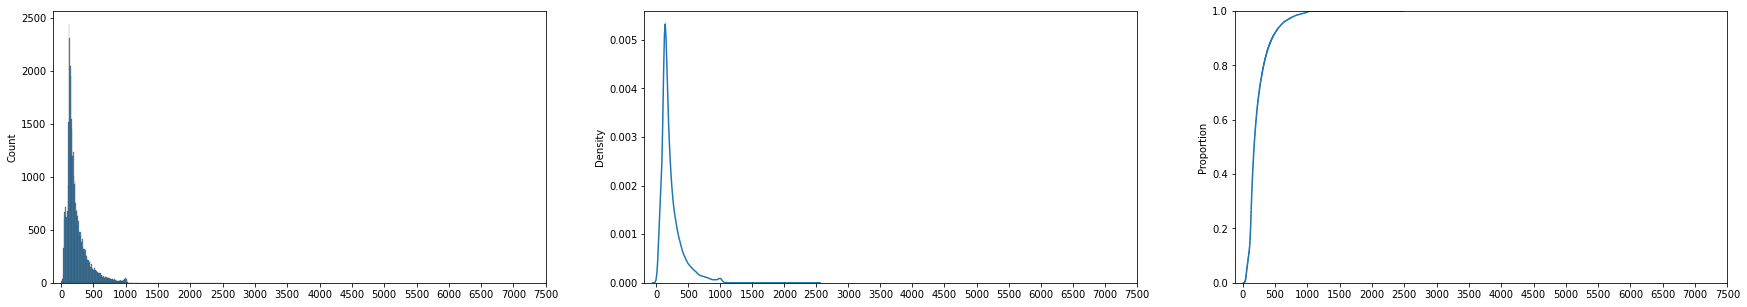

In [7]:
train_review_lengths = []
for review in tqdm(X_train):
  train_review_lengths.append(len(review))
fig, axs = plt.subplots(ncols=3,figsize=(30,5))
a = sns.histplot(data = train_review_lengths,ax=axs[0])
a.set_xticks(range(0,8000,500))
b = sns.kdeplot(data = train_review_lengths,ax=axs[1])
b.set_xticks(range(0,8000,500))
c = sns.ecdfplot(data = train_review_lengths,ax=axs[2])
c.set_xticks(range(0,8000,500))
plt.show()


In [8]:
# truncate and/or pad input sequences
max_review_length = 600
X_train = tf.keras.utils.pad_sequences(X_train, maxlen=max_review_length,padding='post')
X_test = tf.keras.utils.pad_sequences(X_test, maxlen=max_review_length,padding='post')

print(X_train.shape)
print(X_train[1])

(37500, 600)
[   1 7723 6417  659    2 4023   39    2 4134  103 4052    4  341    7
  160 2658 3006 4601  238  181    8  276   90   23   27  768    7    2
   21    4   85 9331  713   18  260   90  187   10   10 1680   18    2
    2    2   56   19   35 7095 3410  123 2056 6579 5354  871 2648   90
    2    5  269    8 9938   23    2   78    2  240  188    8  193   12
   21    2    2  871    2  577 1568  160  282    8 1231  187   10   10
    4  360    7    4   22    9    2 1651    8   79  145    8    4    2
 9813  137   33    4  172   58    2  199    2    5   27 2028  250  464
 4289    2 1276   13   62   28  623    2   59   47   12   32  120    2
   10   10 7723 6417    9 1678   34 1622 1205   33    4 2929    2 4134
    5   52   22  929    7    2 5969   24 1678   34    6  247  710   65
   63    2   83    4  147  282   18    2  712    5   27  247 2270    2
   39  172   10   10  131  451    7    2  238  140   18   14    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    

## Model with single LSTM layer

In [9]:
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(num_words, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(units = 100,activation = 'tanh',kernel_initializer="he_normal"))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 600, 32)           320000    
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 373,301
Trainable params: 373,301
Non-trainable params: 0
_________________________________________________________________
None


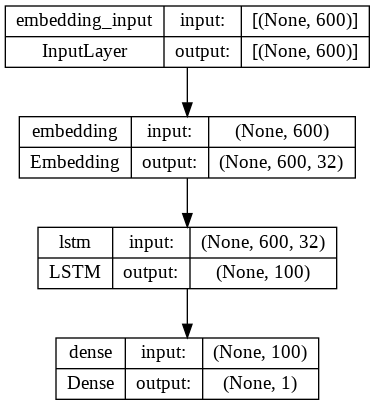

In [10]:
tf.keras.utils.plot_model(model,show_shapes = True)

In [13]:
model.fit(X_train, y_train, epochs=10, batch_size=64,validation_data = (X_test, y_test))
# Final evaluation of the model

Epoch 1/10
586/586 [==============================] - 19s 33ms/step - loss: 0.5688 - accuracy: 0.6744 - val_loss: 0.4091 - val_accuracy: 0.8314
Epoch 2/10
586/586 [==============================] - 19s 32ms/step - loss: 0.3027 - accuracy: 0.8791 - val_loss: 0.2946 - val_accuracy: 0.8817
Epoch 3/10
586/586 [==============================] - 19s 32ms/step - loss: 0.2097 - accuracy: 0.9226 - val_loss: 0.3128 - val_accuracy: 0.8742
Epoch 4/10
586/586 [==============================] - 19s 32ms/step - loss: 0.1627 - accuracy: 0.9421 - val_loss: 0.2967 - val_accuracy: 0.8918
Epoch 5/10
586/586 [==============================] - 19s 33ms/step - loss: 0.1238 - accuracy: 0.9599 - val_loss: 0.3205 - val_accuracy: 0.8902
Epoch 6/10
586/586 [==============================] - 20s 35ms/step - loss: 0.0936 - accuracy: 0.9723 - val_loss: 0.3554 - val_accuracy: 0.8900
Epoch 7/10
586/586 [==============================] - 19s 32ms/step - loss: 0.0726 - accuracy: 0.9808 - val_loss: 0.3716 - val_accuracy:

In [15]:
scores = model.evaluate(X_test, y_test, verbose=0)
print('Model Loss : ' , scores[0])
print("Model Accuracy: %.2f%%" % (scores[1]*100))

Model Loss :  0.46731144189834595
Model Accuracy: 88.50%


## Lets build model using Gru

In [21]:
# create the model
embedding_vecor_length = 32
gru_model = Sequential()
gru_model.add(Embedding(num_words, embedding_vecor_length, input_length=max_review_length))
gru_model.add(GRU(units = 100,activation = 'tanh',kernel_initializer="he_normal"))
gru_model.add(Dense(1, activation='sigmoid'))
gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(gru_model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 600, 32)           320000    
                                                                 
 gru_1 (GRU)                 (None, 100)               40200     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 360,301
Trainable params: 360,301
Non-trainable params: 0
_________________________________________________________________
None


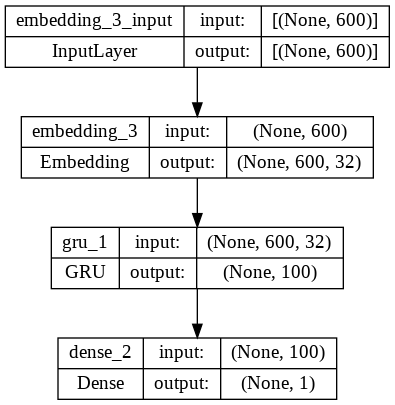

In [22]:
tf.keras.utils.plot_model(gru_model,show_shapes = True)

In [23]:
gru_model.fit(X_train, y_train, epochs=20, batch_size=64,validation_data = (X_test, y_test))
# Final evaluation of the model

Epoch 1/20
586/586 [==============================] - 19s 29ms/step - loss: 0.6934 - accuracy: 0.5006 - val_loss: 0.6921 - val_accuracy: 0.5090
Epoch 2/20
586/586 [==============================] - 17s 29ms/step - loss: 0.6867 - accuracy: 0.5102 - val_loss: 0.6920 - val_accuracy: 0.5018
Epoch 3/20
586/586 [==============================] - 19s 32ms/step - loss: 0.6731 - accuracy: 0.5188 - val_loss: 0.6994 - val_accuracy: 0.5008
Epoch 4/20
586/586 [==============================] - 17s 28ms/step - loss: 0.6671 - accuracy: 0.5229 - val_loss: 0.7097 - val_accuracy: 0.5105
Epoch 5/20
586/586 [==============================] - 16s 27ms/step - loss: 0.6617 - accuracy: 0.5249 - val_loss: 0.7204 - val_accuracy: 0.5098
Epoch 6/20
586/586 [==============================] - 15s 26ms/step - loss: 0.6594 - accuracy: 0.5267 - val_loss: 0.7327 - val_accuracy: 0.5100
Epoch 7/20
586/586 [==============================] - 15s 26ms/step - loss: 0.6587 - accuracy: 0.5283 - val_loss: 0.7379 - val_accuracy:

In [24]:
scores = gru_model.evaluate(X_test, y_test, verbose=0)
print('Model Loss : ' , scores[0])
print("Model Accuracy: %.2f%%" % (scores[1]*100))

Model Loss :  0.7567341327667236
Model Accuracy: 50.05%


## Lets build multi layer lstm model with hyper parameter tuning


In [53]:
def build_model(hp):
  model = Sequential()
  counter = 0
  model.add(
      Embedding(
          input_dim = num_words, 
          output_dim = hp.Choice('embedding_length',values=[50,100,200,300]),
          input_length=max_review_length  
  )
  )
  model.add(
      LSTM(
          units=hp.Int('lstm_units_1', min_value=50, max_value=250, step=50),
           activation=hp.Choice('activation_1',values=['tanh']),
           kernel_initializer = hp.Choice('initialiser_1',values = ['he_normal','glorot_normal']),
          return_sequences = True
      )
      
  )
  model.add(
      LSTM(
          units=hp.Int('lstm_units_2', min_value=50, max_value=250, step=50),
           activation=hp.Choice('activation_2',values=['tanh']),
           kernel_initializer = hp.Choice('initialiser_2',values = ['he_normal','glorot_normal']),
      )
      
  )
  for val in range(hp.Int('num_layers',min_value = 1, max_value =2)):
    model.add(
            Dense(
                hp.Int('dense_units'+str(val), min_value = 100, max_value = 300,step =100),
                activation = hp.Choice('dense_activation'+str(val),values=['relu','tanh','sigmoid']),
                kernel_initializer = hp.Choice('dense_initialiser'+str(val),values = ['he_normal','glorot_normal'])
            ) 
            )

    counter += 1
  model.add(Dense(1,activation = 'sigmoid'))
  model.compile(optimizer = hp.Choice('optimiser', values = ['rmsprop','sgd','adam']),loss='binary_crossentropy',metrics=['accuracy'])
  return model

In [55]:
tuner_random_lstm = kt.RandomSearch(build_model,objective = 'val_accuracy',max_trials = 5, directory = "hyperparametertuning",project_name = 'lstm_random_tuner_2')

In [56]:
tuner_random_lstm.search(X_train, y_train,epochs = 2,validation_data = (X_test, y_test))

Trial 5 Complete [00h 02m 50s]
val_accuracy: 0.5

Best val_accuracy So Far: 0.5223199725151062
Total elapsed time: 00h 16m 02s


In [57]:
tuner_random_lstm.get_best_hyperparameters()[0].values

{'embedding_length': 200,
 'lstm_units_1': 250,
 'activation_1': 'tanh',
 'initialiser_1': 'glorot_normal',
 'lstm_units_2': 100,
 'activation_2': 'tanh',
 'initialiser_2': 'he_normal',
 'num_layers': 2,
 'dense_units0': 200,
 'dense_activation0': 'sigmoid',
 'dense_initialiser0': 'he_normal',
 'optimiser': 'adam',
 'dense_units1': 100,
 'dense_activation1': 'relu',
 'dense_initialiser1': 'he_normal'}

In [58]:
best_model = tuner_random_lstm.get_best_models(num_models = 1)[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 600, 200)          2000000   
                                                                 
 lstm (LSTM)                 (None, 600, 250)          451000    
                                                                 
 lstm_1 (LSTM)               (None, 100)               140400    
                                                                 
 dense (Dense)               (None, 200)               20200     
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 2,631,801
Trainable params: 2,631,801
Non-

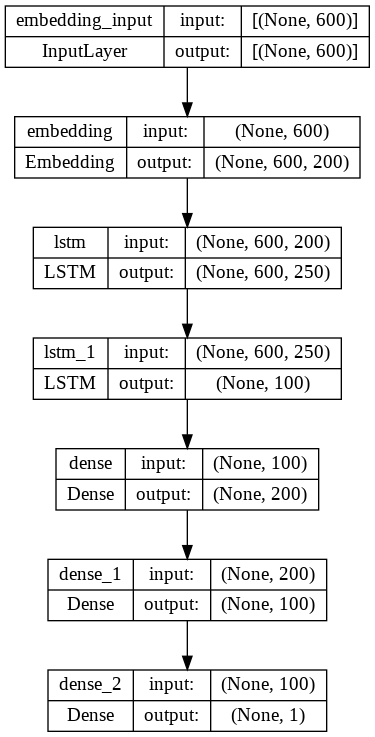

In [61]:
plot_model(best_model, show_shapes=True)

In [62]:
best_model.fit(X_train, y_train, epochs=20, verbose=1, validation_data=(X_test, y_test)) 

Epoch 1/20
1172/1172 [==============================] - 85s 70ms/step - loss: 0.6889 - accuracy: 0.5238 - val_loss: 0.6894 - val_accuracy: 0.5224
Epoch 2/20
1172/1172 [==============================] - 80s 68ms/step - loss: 0.6887 - accuracy: 0.5250 - val_loss: 0.6893 - val_accuracy: 0.5234
Epoch 3/20
1172/1172 [==============================] - 80s 68ms/step - loss: 0.6888 - accuracy: 0.5253 - val_loss: 0.6891 - val_accuracy: 0.5234
Epoch 4/20
1172/1172 [==============================] - 81s 69ms/step - loss: 0.6887 - accuracy: 0.5255 - val_loss: 0.6899 - val_accuracy: 0.5231
Epoch 5/20
1172/1172 [==============================] - 80s 68ms/step - loss: 0.6887 - accuracy: 0.5257 - val_loss: 0.6891 - val_accuracy: 0.5238
Epoch 6/20
1172/1172 [==============================] - 79s 68ms/step - loss: 0.6887 - accuracy: 0.5248 - val_loss: 0.6890 - val_accuracy: 0.5226
Epoch 7/20
1172/1172 [==============================] - 81s 69ms/step - loss: 0.6888 - accuracy: 0.5240 - val_loss: 0.6890 -

In [63]:
score = best_model.evaluate(X_test, y_test, verbose=1) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

391/391 [==============================] - 10s 25ms/step - loss: 0.6891 - accuracy: 0.5219
Test score: 0.6890830397605896
Test accuracy: 0.5219200253486633
